In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
import altair as alt

In [7]:
gamma = 1/14
overall_hosp_rate = 0.025
hosp_market_share = .90
non_icu_los = 7
la["growth_rate"] = la.new_cases / la.cases
la["doubling_time"] = 1.0 / np.log2(la["growth_rate"] + 1)

la["beta"] = la["growth_rate"] + gamma
la['admits'] = la.new_cases * overall_hosp_rate * hosp_market_share
la['admits_floor'] = np.floor(la.admits)
la['census'] = la.admits_floor.cumsum() - la.admits_floor.shift(non_icu_los, fill_value=0).cumsum()

## Find Best SIR Model Based on Actuals

In [9]:
# Mock Input Formats

simulated_sir = pd.DataFrame({
    'date': [],
    's' : [],
    'i': [],
    'r': [],
})

actual_estimated_i = pd.DataFrame({
    'date': [],
    'admits': [],
    'i_est': [], # = admits / hosp_market_share / hospitalization_rate
})

# Preproccesing Functions

In [10]:
def preprocess_admits_data(actual_estimated_i):
    """
    Return rows after the region has hit 10 cases.
    """
    index = actual_estimated_i.i_est.loc[(actual_estimated_i.i_est >= 10)].index[0]
    return actual_estimated_i.iloc[index:].reset_index(drop=True).copy()

def fix_zero_problems(actual_estimated_i):
    """
    In some counties the new cases were be rolled over into the next day,
    leaving one day with zero cases and the next day with too many cases.
    (At least that's what it looked like.) This spreads them back out accross the 
    two days.
    """
    out_cases = [actual_estimated_i.cases.iloc[0]]
    skip = False
    for i in range(1, len(actual_estimated_i) - 1):
        if skip:
            skip = False
            continue
        prev_cases = actual_estimated_i.cases.iloc[i - 1]
        cases = actual_estimated_i.cases.iloc[i]
        next_cases = actual_estimated_i.cases.iloc[i + 1]
        if cases == prev_cases:
            case_diff = next_cases - cases
            take = int(case_diff * .25)
            out_cases.append(cases + take)
            out_cases.append(next_cases - take)
            skip = True
        else:
            out_cases.append(cases)
    if not skip:
        out_cases.append(next_cases)
    actual_estimated_i['cases'] = out_cases
    return actual_estimated_i

# SIR Functions

In [12]:
def sir(start_date, initial_doubling_time, regional_population, infectious_days, simulate_n_days):
    gamma = 1 / infectious_days
    growth_rate = 2 ** (1 / initial_doubling_time) - 1
    beta = (growth_rate + gamma) / (regional_population - 1)
    N = simulate_n_days
    i_n = 1
    s_n = regional_population - i_n
    r_n = 0.
    
    s_a, i_a, r_a = np.zeros(N), np.zeros(N), np.zeros(N)
    
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n

        s = s_n
        i = i_n
        r = r_n
        
        s_n = (-beta * s * i) + s
        i_n = (beta * s * i - gamma * i) + i
        r_n = gamma * i + r
    return s_a, i_a, r_a

In [21]:
def run_sir_penn(beta, gamma, population, num_infected, N):
    i_n = num_infected
    s_n = population - i_n
    r_n = 0.
    inew_n = 1
    
    s_a, i_a, r_a, inew_a = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n
        inew_a[index] = inew_n

        s = s_n
        i = i_n
        r = r_n
        inew = inew_n
        
        s_n = (-beta * s * i) + s
        i_n = (beta * s * i - gamma * i) + i
        r_n = gamma * i + r
        inew_n = (beta * s * i)
    return s_a, i_a, r_a, inew_a

## Read, Preprocess, and Save County Data

In [26]:
d = pd.read_csv('./data/sample_county_data_2020-04-17.csv').assign(date = lambda d: pd.to_datetime(d.date))
county_pop_df = pd.read_csv("./data/county_populations.csv")

In [88]:
# Preprocess
charts = []
df = pd.DataFrame()
for county_name in county_pop_df.county.unique():
    county_name = county_name.strip()
    # print(f"'{county_name}'")
    county_df = d.loc[d.cs == county_name].reset_index().copy()
    county_df_fixed = fix_zero_problems(county_df)
    county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
    county_df["fixed"] = county_df_fixed["new_cases"]
    df = df.append(county_df)
df.head()

,index,date,county,state,fips,cases,deaths,cs,new_cases,fixed
0,0,2020-01-26,Los Angeles,California,6037.0,1,0,Los Angeles_California,1,1
1,1,2020-01-27,Los Angeles,California,6037.0,1,0,Los Angeles_California,0,0
2,2,2020-01-28,Los Angeles,California,6037.0,1,0,Los Angeles_California,0,0
3,3,2020-01-29,Los Angeles,California,6037.0,1,0,Los Angeles_California,0,0
4,4,2020-01-30,Los Angeles,California,6037.0,1,0,Los Angeles_California,0,0


In [89]:
charts = []
for county_name in df.cs.unique():
    # print(f"'{county_name}'")
    county_df = df.loc[df.cs == county_name].reset_index().copy()
    # county_df = fix_zero_problems(county_df)
    # county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
    cols = ["new_cases", "fixed"]
    charts.append(alt
     .Chart(county_df, title=county_name)
     .transform_fold(cols)
     .encode(x='date:T', y="value:Q", 
             color=alt.Color('key:N', scale=alt.Scale(domain=cols,)))
     .mark_line()
    )
alt.vconcat(*charts)

alt.VConcatChart(...)

# Find number of currently infected

In [70]:
charts = []
for county_name in df.cs.unique():
    # print(f"'{county_name}'")
    county_df = df.loc[df.cs == county_name].reset_index().copy()
    county_df = fix_zero_problems(county_df)
    county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
    county_df["infected_14"] = county_df.cases - county_df.cases.shift(14, fill_value=0)
    county_df["infected_10"] = county_df.cases - county_df.cases.shift(10, fill_value=0)
    county_df["infected_7"] = county_df.cases - county_df.cases.shift(7, fill_value=0)
    county_df["infected_3"] = county_df.cases - county_df.cases.shift(3, fill_value=0)
    cols = ["cases", "new_cases", "infected_3", "infected_7", "infected_10", "infected_14"]
    charts.append(alt
     .Chart(county_df, title=county_name)
     .transform_fold(cols)
     .encode(x='date:T', y="value:Q", 
             color=alt.Color('key:N', scale=alt.Scale(domain=cols,)))
     .mark_line()
    )
alt.vconcat(*charts)

alt.VConcatChart(...)

In [22]:
infectious_days = 14.
doubling_rate = 5
population = 1000000.
num_infected = 100.
N = 250

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta = (growth_rate + gamma) / (population - 1)

s, i, r, i_new = run_sir_penn(beta, gamma, population, num_infected, N)

In [23]:
d = pd.DataFrame({
    'day': np.arange(len(s)), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

(alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='day:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

In [24]:
def doubling_times(i):
    i_cumulative = np.cumsum(i)
    delta = np.diff(i_cumulative, 1)
    growth_rate = delta / i_cumulative[1:]
    return 1 / np.log2(growth_rate + 1)

In [6]:
d_times = doubling_times(i_new)
rate = np.diff(d_times, 1)
d_time = pd.DataFrame({
    'day': np.arange(len(s) - 2), 
    'doubling_time': d_times[:-1],
    'rate_of_increase': rate,
})

(alt
 .Chart(d_time.iloc[:100])
 .encode(x='day:Q', y='doubling_time:Q')
 .mark_line()
)

alt.Chart(...)

# Jason Method

1. Get doubling time from cumulative cases
2. Find segments using algorithm or linear model
3. block segments into single growth rates

In [90]:
params = []
overall_hosp_rate = 1
hosp_market_share = 1
non_icu_los = 7
infectious_days = 14
min_cases = 10

for county_name in county_pop_df.county:
    county_name = county_name.strip()
    print(f"'{county_name}'")
    county_df = d.loc[d.cs == county_name].reset_index().copy()
    county_df = fix_zero_problems(county_df)
    county_population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
    county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
    county_df = county_df[["date", "cases", "new_cases"]]

    county_df['admits'] = county_df.new_cases * overall_hosp_rate * hosp_market_share
    county_df['admits_floor'] = np.floor(county_df.admits)
    county_df['census'] = county_df.admits_floor.cumsum() - county_df.admits_floor.shift(non_icu_los, fill_value=0).cumsum()
    actual_estimated_i = county_df[['date', 'admits', 'admits_floor']].copy()
    actual_estimated_i['i_est'] = actual_estimated_i.admits / hosp_market_share / overall_hosp_rate
    if actual_estimated_i.i_est.max() < min_cases:
        print("Too few cases\n")
        continue
    actual_estimated_i = preprocess_admits_data(actual_estimated_i)
    best_loss = fit(actual_estimated_i, county_population, infectious_days)
    params.append({'name': county_name, 'loss': best_loss, 'actual_estimated_i': actual_estimated_i})
    print()


'Los Angeles_California'
Grid size: 780

'San Francisco_California'
Grid size: 780

'Salt Lake_Utah'
Grid size: 780

'King_Washington'
Grid size: 780

'New York City_New York'
Grid size: 780

'Grafton_New Hampshire'
Too few cases

'Washoe_Nevada'
Grid size: 780

'Santa Fe_New Mexico'
Too few cases

'Lake_Illinois'
Grid size: 780

'Albany_New York'
Grid size: 780

'Litchfield_Connecticut'
Grid size: 780

'Sarasota_Florida'
Grid size: 780

'Ada_Idaho'
Grid size: 780

'Lubbock_Texas'
Grid size: 780

'Broomfield_Colorado'
Too few cases

'Somerset_Maryland'
Too few cases

'Columbia_Oregon'
Too few cases



In [28]:
import pickle

with open("./county_fits.pkl", 'wb') as handle:
    pickle.dump(params, handle)

In [93]:
county_name = 'Albany_New York'
county_df = d.loc[d.cs == county_name].reset_index().copy()
county_df = fix_zero_problems(county_df)
county_population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
county_df = county_df[["date", "cases", "new_cases"]]

county_df['admits'] = county_df.new_cases * overall_hosp_rate * hosp_market_share
county_df['admits_floor'] = np.floor(county_df.admits)
county_df['census'] = county_df.admits_floor.cumsum() - county_df.admits_floor.shift(non_icu_los, fill_value=0).cumsum()

In [95]:
county_df.iloc[:30]

,date,cases,new_cases,admits,admits_floor,census
0,2020-03-12,2,2,2.0,2.0,2.0
1,2020-03-13,2,0,0.0,0.0,2.0
2,2020-03-14,5,3,3.0,3.0,5.0
3,2020-03-15,11,6,6.0,6.0,11.0
4,2020-03-16,12,1,1.0,1.0,12.0
5,2020-03-17,23,11,11.0,11.0,23.0
6,2020-03-18,36,13,13.0,13.0,36.0
7,2020-03-19,43,7,7.0,7.0,41.0
8,2020-03-20,61,18,18.0,18.0,59.0
9,2020-03-21,88,27,27.0,27.0,83.0


In [49]:
d.loc[d.cs == "Washoe_Nevada"]

,date,county,state,fips,cases,deaths,cs
95,2020-03-05,Washoe,Nevada,32031.0,1,0,Washoe_Nevada
102,2020-03-06,Washoe,Nevada,32031.0,1,0,Washoe_Nevada
109,2020-03-07,Washoe,Nevada,32031.0,1,0,Washoe_Nevada
116,2020-03-08,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
123,2020-03-09,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
130,2020-03-10,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
138,2020-03-11,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
149,2020-03-12,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
162,2020-03-13,Washoe,Nevada,32031.0,2,0,Washoe_Nevada
175,2020-03-14,Washoe,Nevada,32031.0,4,0,Washoe_Nevada


### Visualize Fits

In [91]:
charts = []
overall_hosp_rate = 1.
hosp_market_share = 1.
for param_obj in params:
    county_name = param_obj['name']
    county_df = d.loc[d.cs == county_name].reset_index().copy()
    county_df = fix_zero_problems(county_df)
    county_population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
    county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
    county_df = county_df[["date", "cases", "new_cases"]]

    county_df['admits'] = county_df.new_cases * overall_hosp_rate * hosp_market_share
    county_df['admits_floor'] = np.floor(county_df.admits)
    loss_obj = param_obj['loss']
    actual_estimated_i = param_obj['actual_estimated_i']
    population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
    chart = plot_actuals_versus_projected(county_df, loss_obj, county_name, overall_hosp_rate, hosp_market_share, population)
    charts.append(chart)

In [92]:
alt.vconcat(*charts)

alt.VConcatChart(...)

### Taking a Peek at Albany

In [105]:
overall_hosp_rate = 1
hosp_market_share = 1
non_icu_los = 7
infectious_days = 14
min_cases = 10

county_name = 'Albany_New York'
county_df = d.loc[d.cs == county_name].reset_index().copy()
county_df = fix_zero_problems(county_df)
county_population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
county_df["new_cases"] = county_df.cases - county_df.cases.shift(fill_value=0)
county_df = county_df[["date", "cases", "new_cases"]]

county_df['admits'] = county_df.new_cases * overall_hosp_rate * hosp_market_share
county_df['admits_floor'] = np.floor(county_df.admits)
county_df['census'] = county_df.admits_floor.cumsum() - county_df.admits_floor.shift(non_icu_los, fill_value=0).cumsum()
actual_estimated_i = county_df[['date', 'admits', 'admits_floor']].copy()
actual_estimated_i['i_est'] = actual_estimated_i.admits / hosp_market_share / overall_hosp_rate
if actual_estimated_i.i_est.max() < min_cases:
    print("Too few cases\n")
actual_estimated_i = preprocess_admits_data(actual_estimated_i)
losses = fit(actual_estimated_i, county_population, infectious_days, return_all_losses=True)
losses.sort(key=lambda l: l['error'])


Grid size: 780


In [108]:
charts = []
for loss_obj in losses[:10]:
    population = county_pop_df.loc[county_pop_df.county == county_name, 'population'].iloc[0]
    chart = plot_actuals_versus_projected(county_df, loss_obj, str(loss_obj['error']), overall_hosp_rate, hosp_market_share, population)
    charts.append(chart)
alt.vconcat(*charts)

alt.VConcatChart(...)

In [99]:
loss_obj

{'error': 18.31683187415188,
 'start_date': Timestamp('2020-03-28 00:00:00', freq='D'),
 'doubling_time': 3}

In [98]:
chart

alt.HConcatChart(...)

## Scratch

In [7]:
la.to_csv("la_doubling.csv", index=False)

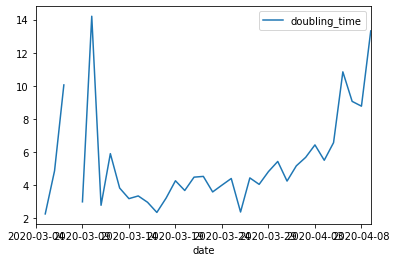

In [6]:
la.plot('date', 'doubling_time')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [9]:
x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0, 2*np.pi, np.pi/50)
ynew = interpolate.splev(xnew, tck, der=0)

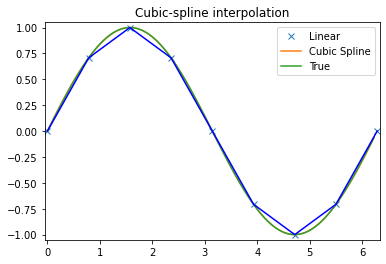

In [10]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
plt.legend(['Linear', 'Cubic Spline', 'True'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

In [16]:
xnew2 = np.arange(-2*np.pi, 4*np.pi, np.pi/50)
ynew2 = interpolate.splev(xnew2, tck, der=0)

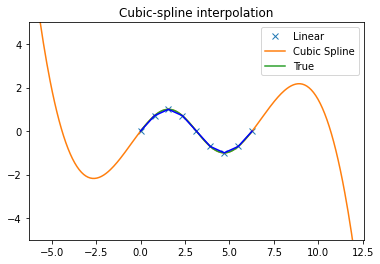

In [18]:
plt.figure()
plt.plot(x, y, 'x', xnew2, ynew2, xnew, np.sin(xnew), x, y, 'b')
plt.legend(['Linear', 'Cubic Spline', 'True'])
plt.axis([-2*np.pi, 4*np.pi, -5, 5])
plt.title('Cubic-spline interpolation')
plt.show()

In [63]:
d = la[5:]
x = list(range(len(d)))
y = d.doubling_time
s = interpolate.UnivariateSpline(x, y, s=120)

In [64]:
s.get_knots()

array([ 0., 16., 31.])

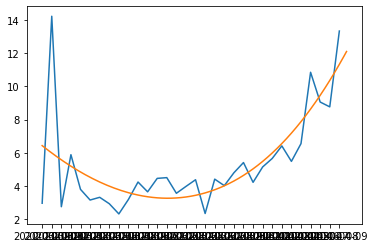

In [65]:
new_x = np.arange(0, len(x), .25)
new_y = s(new_x)
plt.plot(d.date, d.doubling_time, new_x, new_y)

In [33]:
y

38          NaN
39     2.234842
40     4.843767
41    10.046649
42          inf
43     2.967051
44    14.206699
45     2.758087
46     5.884949
47     3.801784
48     3.159821
49     3.323734
50     2.939198
51     2.325647
52     3.197059
53     4.242433
54     3.653638
55     4.461241
56     4.506478
57     3.566022
58     3.978288
59     4.379952
60     2.350831
61     4.415665
62     4.025238
63     4.797757
64     5.412688
65     4.223628
66     5.148448
67     5.659768
68     6.415017
69     5.483772
70     6.550560
71    10.839109
72     9.050599
73     8.760388
74    13.317652
Name: doubling_time, dtype: float64

In [46]:
gamma = 1/14

growth_rate = la_train.admits / la_train.cases
doubling_time = 1.0 / np.log2(growth_rate + 1)
beta = growth_rate + gamma

# Print doubling time and beta from each time step
for val1, val2 in zip(doubling_time, beta):
    print("doubling time: ", val1)
    print("beta: ", val2)
    print(" ")

doubling time:  2.3508306166837216
beta:  0.41435620300751874
 
doubling time:  4.415665203162323
beta:  0.24139444173573865
 
doubling time:  4.025238058736619
beta:  0.25934431422236304
 
doubling time:  4.797756627452325
beta:  0.2268592830390583
 
doubling time:  5.4126878376129435
beta:  0.208049428340455
 
doubling time:  4.223627535779114
beta:  0.2497746358589932
 


In [52]:
# This might do it for SIR from data?
population = 130000
market_share = 100
la_train["r"] = la_train.cases.shift()*gamma
la_train["s"] = population - la_train.cases
la_train["i"] = population - la_train["s"] - la_train["r"]
la_train[["date", "cases", "admits", "s", "i", "r"]]

,date,cases,admits,s,i,r
60,2020-03-26,1216,417.0,128784,NaN,NaN
61,2020-03-27,1465,249.0,128535,1378.142857,86.857143
62,2020-03-28,1804,339.0,128196,1699.357143,104.642857
63,2020-03-29,2136,332.0,127864,2007.142857,128.857143
64,2020-03-30,2474,338.0,127526,2321.428571,152.571429
65,2020-03-31,3011,537.0,126989,2834.285714,176.714286


In [47]:
# Generated Admits and Census Data (Pretend a client gave us these)
admits_df = pd.read_csv("admits_test.csv")
# census_df = pd.read_csv("census_test.csv")
sir_df = pd.read_csv("sir_test.csv")


In [56]:
# put cases on admits
admits_df["cases"] = np.empty(admits_df.shape[0])
admits_df["cases"] = 0
admits_df["total_float"] = admits_df.non_icu + admits_df.icu
admits_df["cases"] = np.cumsum(admits_df.total_float.shift(1))

sir_sample = sir_df.loc[sir_df.date >= "2020-05-10"]
sir_sample = sir_sample.loc[sir_sample.date < "2020-05-31"]

admits_sample = admits_df.loc[admits_df.date >= "2020-05-10"]
admits_sample = admits_sample.loc[admits_sample.date < "2020-05-31"]
admits_sample

,day,date,non_icu,icu,ventilators,total,cases,total_float
41,24,2020-05-10,265.280562,265.280562,2.652806,530.0,2810.642382,530.561124
42,25,2020-05-11,315.111446,315.111446,3.151114,630.0,3341.203506,630.222891
43,26,2020-05-12,374.221570,374.221570,3.742216,748.0,3971.426397,748.443140
44,27,2020-05-13,444.305473,444.305473,4.443055,888.0,4719.869537,888.610946
45,28,2020-05-14,527.353391,527.353391,5.273534,1054.0,5608.480483,1054.706783
46,29,2020-05-15,625.697165,625.697165,6.256972,1250.0,6663.187266,1251.394331
47,30,2020-05-16,742.060856,742.060856,7.420609,1484.0,7914.581597,1484.121712
48,31,2020-05-17,879.615442,879.615442,8.796154,1758.0,9398.703308,1759.230885
49,32,2020-05-18,1042.036305,1042.036305,10.420363,2084.0,11157.934193,2084.072610
50,33,2020-05-19,1233.561215,1233.561215,12.335612,2466.0,13242.006803,2467.122430


In [57]:
# Calculate SIR from those cases data
population = 1000000
market_share = 100
gamma = 1/14
hosp_rate = 0.0075 + 0.025

sir_calc = pd.DataFrame()
sir_calc["date"] = admits_sample.date
sir_calc["cases"] = admits_sample.cases
sir_calc["admits"] = admits_sample.total_float

sir_calc["i_calc"] = admits_sample.cases
sir_calc["s_calc"] = 0 # population - admits_sample.cases
sir_calc["r_calc"] = 0 # population - sir_calc["s_calc"] - sir_calc["r_calc"]

sir_calc["s"] = sir_sample.susceptible
sir_calc["i"] = sir_sample.infected
sir_calc["r"] = sir_sample.recovered

sir_calc["s_delta"] = sir_sample.susceptible - sir_calc.s_calc
sir_calc["i_delta"] = sir_sample.infected - sir_calc.i_calc
sir_calc["r_delta"] = sir_sample.recovered - sir_calc.r_calc

sir_calc[["date", "cases", "admits", "s", "i", "r", "s_calc", "i_calc", "r_calc", "s_delta", "i_delta", "r_delta"]]

,date,cases,admits,s,i,r,s_calc,i_calc,r_calc,s_delta,i_delta,r_delta
41,2020-05-10,2810.642382,530.561124,996656.796494,2426.128707,917.074799,0,2810.642382,0,996656.796494,-384.513675,917.074799
42,2020-05-11,3341.203506,630.222891,996026.573603,2883.056690,1090.369707,0,3341.203506,0,996026.573603,-458.146815,1090.369707
43,2020-05-12,3971.426397,748.443140,995278.130463,3425.567209,1296.302327,0,3971.426397,0,995278.130463,-545.859188,1296.302327
44,2020-05-13,4719.869537,888.610946,994389.519517,4069.494783,1540.985700,0,4719.869537,0,994389.519517,-650.374754,1540.985700
45,2020-05-14,5608.480483,1054.706783,993334.812734,4833.523367,1831.663898,0,5608.480483,0,993334.812734,-774.957116,1831.663898
46,2020-05-15,6663.187266,1251.394331,992083.418403,5739.666029,2176.915567,0,6663.187266,0,992083.418403,-923.521237,2176.915567
47,2020-05-16,7914.581597,1484.121712,990599.296692,6813.811596,2586.891712,0,7914.581597,0,990599.296692,-1100.770001,2586.891712
48,2020-05-17,9398.703308,1759.230885,988840.065807,8086.341652,3073.592541,0,9398.703308,0,988840.065807,-1312.361656,3073.592541
49,2020-05-18,11157.934193,2084.072610,986755.993197,9592.818430,3651.188373,0,11157.934193,0,986755.993197,-1565.115763,3651.188373
50,2020-05-19,13242.006803,2467.122430,984288.870767,11374.739544,4336.389689,0,13242.006803,0,984288.870767,-1867.267259,4336.389689


In [28]:
# Just scratchwork below.

# Doesn't change
population = 328200000
# Varies with time
for i0, r_act, cd in zip(x0, cum_rec, cum_dead):
    r_calc = i0 * 1/14
    s_calc = population - i0 - r_calc
    print("s: ", s_calc)
    print("i: ", i0)
    print("rc: ", r_calc)
    print("r_act: ", r_act+cd)
    print("  ")

s:  328162242.85714287
i:  35240
rc:  2517.1428571428573
r_act:  1140
  
s:  328151709.64285713
i:  45071
rc:  3219.3571428571427
r_act:  1697
  
s:  328140349.28571427
i:  55674
rc:  3976.714285714286
r_act:  2206
  
s:  328125364.28571427
i:  69660
rc:  4975.714285714285
r_act:  3172
  
s:  328107246.4285714
i:  86570
rc:  6183.571428571428
r_act:  4131
  
s:  328087111.0714286
i:  105363
rc:  7525.928571428572
r_act:  5341
  
s:  328065626.78571427
i:  125415
rc:  8958.214285714286
r_act:  6893
  


In [49]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def sim_sir(
    s: float, i: float, r: float, gamma: float, i_day: int, beta: np.array
):
    """Simulate SIR model forward in time, returning a dictionary of daily arrays
    Parameter order has changed to allow multiple (beta, n_days)
    to reflect multiple changing social distancing policies.
    """
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    d = i_day
    

    s_a = np.empty(n_days, "float")
    i_a = np.empty(n_days, "float")
    r_a = np.empty(n_days, "float")
    beta_a = np.empty(n_days, "float")

    index = 0
    for _ in range(n_days):
        beta = 
        d_a[index] = d
        s_a[index] = s
        i_a[index] = i
        r_a[index] = r
        index += 1

        s, i, r = sir(s, i, r, beta, gamma, n)
        d += 1

    d_a[index] = d
    s_a[index] = s
    i_a[index] = i
    r_a[index] = r
    return {
        "day": d_a,
        "susceptible": s_a,
        "infected": i_a,
        "recovered": r_a,
        "ever_infected": i_a + r_a
    }


def build_sim_sir_w_date_df(
    raw_df: pd.DataFrame,
    current_date: datetime,
    keys: Sequence[str],
) -> pd.DataFrame:
    day = raw_df.day
    return pd.DataFrame({
        "day": day,
        "date": day.astype('timedelta64[D]') + np.datetime64(current_date),
        **{
            key: raw_df[key]
            for key in keys
        }
    })

sim_sir()